
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import re

# Bibliotecas para preparação dos dados
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout

#### Tarefa: Classificação de ratings das avaliações de clientes:
- 4 e 5: Positiva
- 1 e 2: Negativa
- 3: Descartadas


#### Importação do dataset

In [58]:
df = pd.read_csv('../datasets/B2WProcessed.csv')

#### Removendo colunas que não serão utilizadas

In [59]:
columns_to_remove = ['textoOriginal', 'textoOriginalToken', 'textoProcessadoToken']

In [60]:
df = df.drop(columns=columns_to_remove, axis=1)

In [61]:
df.head(3)

,alvo,textoProcessado
0,1,estou contente com a compra entrega rpida o ni...
1,1,por apenas reu consegui comprar esse lindo cop...
2,1,supera em agilidade e praticidade outras panel...


In [62]:
new_column_names = {
    'alvo' : 'rating',
    'textoProcessado' : 'review_text'
}

In [63]:
df.rename(columns=new_column_names, inplace=True)

In [64]:
df.head(3)

,rating,review_text
0,1,estou contente com a compra entrega rpida o ni...
1,1,por apenas reu consegui comprar esse lindo cop...
2,1,supera em agilidade e praticidade outras panel...


#### Pré-processamento

#### Verificando registros nulos

In [65]:
df.isnull().any()

rating         False
review_text     True
dtype: bool

In [66]:
df['review_text'].isnull().sum()

3062

In [67]:
df[df['review_text'].isnull()]

,rating,review_text
31,0,NaN
38,1,NaN
61,1,NaN
98,0,NaN
351,0,NaN
...,...,...
115784,1,NaN
115837,0,NaN
115849,0,NaN
115929,0,NaN


#### Removendo registros nulos

In [68]:
df = df.dropna()

In [69]:
df.isnull().any()

rating         False
review_text    False
dtype: bool

In [70]:
df.shape

(112996, 2)

#### Padronizando texto em lowercase

In [71]:
def to_lowercase(text):
    text = text.apply(lambda x: " ".join(x.lower().split()) if isinstance(x, str) else "")
    return text

In [72]:
df["review_text"] = to_lowercase(df["review_text"])

#### Removendo caracteres especiais e substituindo cedilhas por c

In [73]:
def preprocess_text(text):
    # removendo caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    # unidecode translitera caracteres acentuados e especiais para formas sem acento ou caracteres equivalentes
    text = unidecode(text)
    return text

In [74]:
df['review_text'] = [preprocess_text(doc) for doc in df['review_text']]

#### Removendo hiperlinks

In [75]:
def remove_hiperlink(text):
    text = re.sub(r"(https?://[^\s]+|www\.[^\s]+)", '', text)
    return text

In [76]:
df['review_text'] = [remove_hiperlink(doc) for doc in df['review_text']]

#### Descartando instâncias com avaliação igual a 3

In [77]:
rating_3 = df['rating'] == 3
rating_3.sum()

0

In [78]:
df = df[df['rating'] != 3]

In [79]:
df.shape

(112996, 2)

#### Ajustando ratings:
- 1 e 2 = 0
- 4 e 5 = 1

In [82]:
df_rating_counts = df['rating'].value_counts()

In [83]:
print(f'{df_rating_counts[1]} Avaliações Positivas')
print(f'{df_rating_counts[0]} Avaliações Negativas')

79230 Avaliações Positivas
33766 Avaliações Negativas


In [49]:
# Caso necessite binarização
#df['rating'] = list(map(lambda x: 0 if x<=2 else 1, df['rating']))

In [54]:
#df_count = df['rating'].value_counts()

#### Nota-se que o dataset está desbalanceado

In [85]:
def plot_barchart(data):
    rating_counts = data
    labels = [f'{data[1]} Avaliações Positivas', f'{data[0]} Avaliações Negativas']

    # Criar o gráfico de barras
    plt.bar(labels, rating_counts)

    # Adicionar rótulos e título
    plt.xlabel('Ratings')
    plt.ylabel('Contagem')
    plt.title('Gráfico de Barras de Ratings')

    # Mostrar o gráfico
    plt.show()

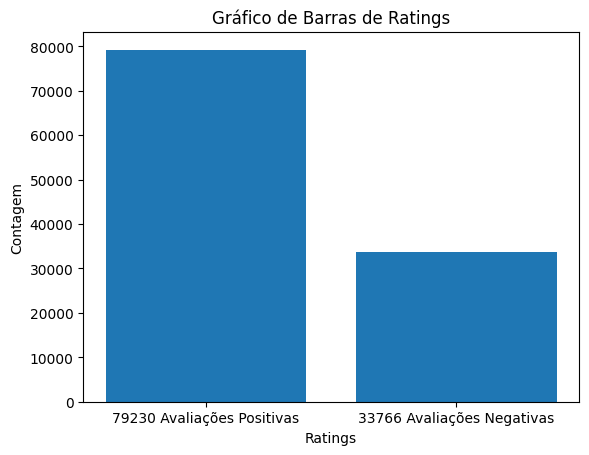

In [86]:
plot_barchart(df_rating_counts)

#### Utilizar a técnica de reamostragem RandomOverSampler para resolver o problema de desbalanceamento das classes
- Esta técnica gera novas amostras aleatórias para a classe minoritária;
- Desta forma tenta igualar número de amostras da classe majoritária;

#### No caso do datase b2w iremos utilizar RandomUnderSampler para tentar iguar ao número da classe minoritária

In [89]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [90]:
# Gerando uma cópia do dataset
df_balanced = df.copy()

In [91]:
rus = RandomUnderSampler()

In [32]:
# Criando uma instância do RandomOverSampler
ros = RandomOverSampler()

#### Separarando os recursos (X) e os rótulos (y)

In [92]:
# Alterarando o shape dos dados para uma representação com uma única coluna
# Os dados foram mantidos, mas agora X possui uma coluna adicional, tornando-se uma matriz bidimensional em vez de uma matriz unidimensional
X = np.array(df_balanced['review_text'])
X = X.reshape(-1, 1)

In [93]:
y = df_balanced['rating']

In [94]:
# Aplicando o RandomOverSampler para gerar novas amostras
X_res, y_res = rus.fit_resample(X, y)

In [95]:
print(pd.Series(y_res).value_counts())

rating
0    33766
1    33766
Name: count, dtype: int64


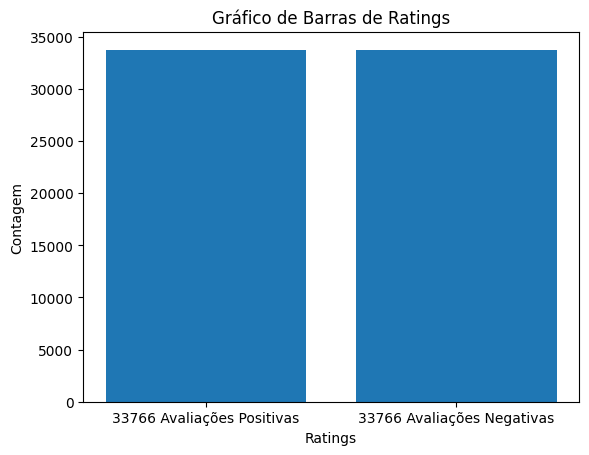

In [128]:
plot_barchart(y_res.value_counts())

In [167]:
def clear_sentences(sentences):
    new_list_texts = []
    for item in sentences:
        item = str(item)
        item_fixed = item[1:-1]  
        new_list_texts.append(item_fixed)
    
    return [s[1:-1] for s in new_list_texts]

In [172]:
texts = clear_sentences(X_res)
labels = y_res

In [173]:
df_balanced = {
    'review_text' : texts,
    'rating' : labels
}

In [174]:
preprocessed_balanced_df = pd.DataFrame(df_balanced)

In [175]:
preprocessed_balanced_df.head(3)

,review_text,rating
0,meu produto nao foi entregue e a americanas es...,0
1,esse celular no vale nada a bateria no vale na...,0
2,a mochila nao esta fechando direito por isso n...,0


In [178]:
preprocessed_balanced_df.to_csv('../datasets/b2w_preprocessed_balanced_cleared.csv', index=False)